In [5]:
import glob
import pandas as pd
from datetime import datetime
import os
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from tqdm import tqdm

# 1. Samsung

In [6]:
output_dir = '../Data/Samsung/samsung-security-updates'

# List to hold dataframes
dfs = []

# List all CSVs in the directory
csv_files = [f for f in os.listdir(output_dir) if f.endswith('.csv')]

# Iterate over each file with progress bar
for file in tqdm(csv_files, desc="Loading CSVs"):
    # Read the CSV and append to the list
    dfs.append(pd.read_csv(f"{output_dir}/{file}"))

# Concatenate all dataframes in the list
df_samsung = pd.concat(dfs, ignore_index=True)

Loading CSVs: 100%|█████████████████████████████| 40/40 [00:03<00:00, 10.54it/s]


## 1.1 Feature extraction for all pairs (~7mins)

In [13]:
import pandas as pd
import datetime
import matplotlib.dates as mdates
import numpy as np
from tqdm import tqdm  

df_knox_models = pd.read_csv('../Data/Samsung/knox-models-all.csv')
df_csc = pd.read_csv('../Data/Samsung/CSC-list.csv')

df_samsung["security_patch_level"] = df_samsung["security_patch_level"].astype("datetime64")
df_samsung["release_date"] = df_samsung["release_date"].astype("datetime64")


d = []

unique_ids = df_samsung['id'].unique()

# Wrap the loop with tqdm for progress bar
pbar = tqdm(unique_ids, desc="Processing Records", dynamic_ncols=True)

for idx, i in enumerate(pbar):
    
    #get the model and CSC code from the unique pair id
    [model,CSC] = i.split('/')
    
    #extract carrier_country from CSC dataset
    cc= df_csc[df_csc['CSC']==CSC]['carrier/country'].to_list()
    carrier_country = cc[0]
    
    #extract carrier from CSC dataset
    car = df_csc[df_csc['CSC']==CSC]['carrier'].to_list()
    carrier = car[0]
    
    #extract country from CSC dataset
    cou = df_csc[df_csc['CSC']==CSC]['country'].to_list()
    country = cou[0]
    
    #extract ISO code from CSC dataset
    iso = df_csc[df_csc['CSC']==CSC]['iso_code'].to_list()
    iso_code = iso[0]
    
    #extract region from CSC dataset
    reg = df_csc[df_csc['CSC']==CSC]['region'].to_list()
    region = reg[0]
    
    #extract subregion from CSC dataset
    subreg = df_csc[df_csc['CSC']==CSC]['subregion'].to_list()
    subregion = subreg[0]

    #extract knox device from model
    k = df_knox_models.loc[df_knox_models['model']==model,'device'].to_list()
    if len(k) == 1:
        device = k[0]
    else:
        device = ''
        
    #extract device type knox devices
    dt = df_knox_models.loc[df_knox_models['model']==model,'device_type'].to_list()
    if len(dt) == 1:
        device_type= dt[0]
    else:
        device_type = ''

    #CALCULATE FEATURES
    #filter the dataset for the unique pair
    df_test = df_samsung[df_samsung['id']==i]
    
    #get the url
    url = 'https://doc.samsungmobile.com/' + i + '/doc.html'
    
    #extract all unique android version used for the unique pair
    android_versions = df_test['android_version'].unique()
    first_OS = df_test.sort_values('release_date',ascending=False)['android_version'].iat[-1]
    last_OS = df_test.sort_values('release_date',ascending=False)['android_version'].iat[0]

    #extract SPLs for the unique pair
    SPL_dates = df_test['security_patch_level']
    
    #calculate other fetures from SPL array for for the unique pair
    first_SPL = SPL_dates.min()
    last_SPL = SPL_dates.max()
    SPL_duration = SPL_dates.max()- SPL_dates.min()
    SPL_count = len(SPL_dates)
    SPL_freq = SPL_duration.days/SPL_count
    
    #extract Release dates for the unique pair
    release_dates = df_test['release_date']
    
    #calculate other fetures from ReleaseDates array for for the unique pair
    first_release_date = release_dates.min()
    last_release_date = release_dates.max()
    release_date_duration = release_dates.max() - release_dates.min()
    release_count = len(release_dates)
    avg_release_freq = release_date_duration.days/release_count
    
    #calculate avg delay in the release dates and SPL dates
    avg_release_delay = (df_test['release_date']-df_test['security_patch_level']).mean().days
    
    
    a = df_knox_models.loc[df_knox_models.model==model,'AER'].to_list()
    
    if len(a) >= 1:
        aer = a[0]
    else:
        aer = False
        
    p = df_knox_models.loc[df_knox_models.model==model,'platform'].to_list()
    
    if len(p) >= 1:
        platform = p[0]
    else:
        platform = 'No-Info'
        
    
    #create the final array
    d.append({'id': i,
             'device': device,
             'model': model,
             'CSC': CSC,
             'device_type': device_type,
             'aer': aer,
             'platform': platform,
             'carrier_country': carrier_country,
             'carrier': carrier,
             'country': country,
             'iso_code': iso_code,
             'region': region,
             'subregion': subregion,
             'android_versions': android_versions,
             'android_versions_str': ','.join(android_versions),
             'android_versions_count': len(android_versions),
             'first_OS': first_OS,
             'last_OS': last_OS,
             'first_SPL': first_SPL,
             'last_SPL': last_SPL,
             'SPL_duration': SPL_duration,
             'release_date_duration': release_date_duration,
             'SPL_count': SPL_count,
             'release_count': release_count,
             'SPL_freq': SPL_freq,
             'avg_release_freq': avg_release_freq,
             'first_release_date': first_release_date,
             'last_release_date': last_release_date,
             'avg_release_delay': avg_release_delay,
             'url': url})

df_final_samsung = pd.DataFrame(d)

df_final_samsung.to_csv('../Data/Samsung/Samsung_security_updates_history_features.csv',index=False)

df_final_samsung.head()


Processing Records: 100%|█████████████████| 21461/21461 [07:27<00:00, 47.91it/s]


,id,device,model,CSC,device_type,aer,platform,carrier_country,carrier,country,...,SPL_duration,release_date_duration,SPL_count,release_count,SPL_freq,avg_release_freq,first_release_date,last_release_date,avg_release_delay,url
0,SM-A530F/ORO,Galaxy A8 (2018),SM-A530F,ORO,smartphone,False,Knox,Romania (Orange),Orange,Romania,...,1219 days,1330 days,34,34,35.852941,39.117647,2018-04-27,2021-12-17,38.0,https://doc.samsungmobile.com/SM-A530F/ORO/doc...
1,SM-A530F/ORS,Galaxy A8 (2018),SM-A530F,ORS,smartphone,False,Knox,Slovakia,No-carrier,Slovakia,...,1219 days,1330 days,34,34,35.852941,39.117647,2018-04-27,2021-12-17,39.0,https://doc.samsungmobile.com/SM-A530F/ORS/doc...
2,SM-A530F/ORX,Galaxy A8 (2018),SM-A530F,ORX,smartphone,False,Knox,Slovakia,No-carrier,Slovakia,...,1219 days,1420 days,40,40,30.475000,35.500000,2018-01-16,2021-12-06,29.0,https://doc.samsungmobile.com/SM-A530F/ORX/doc...
3,SM-A530F/PAK,Galaxy A8 (2018),SM-A530F,PAK,smartphone,False,Knox,Pakistan (PAK),PAK,Pakistan,...,1219 days,1457 days,36,36,33.861111,40.472222,2018-01-24,2022-01-20,30.0,https://doc.samsungmobile.com/SM-A530F/PAK/doc...
4,SM-A530F/PAN,Galaxy A8 (2018),SM-A530F,PAN,smartphone,False,Knox,Hungary (Telenor),Telenor,Hungary,...,1219 days,1309 days,22,22,55.409091,59.500000,2018-05-04,2021-12-03,36.0,https://doc.samsungmobile.com/SM-A530F/PAN/doc...


- Saving the last OS and last security update dates for unpatched analysis

In [14]:
df_final_samsung_new= df_final_samsung.rename(columns={"last_OS": "last_android_version", "last_release_date": "last_update_date"},inplace=False)
df_final_samsung_new[['id','device','last_android_version','last_update_date']].to_csv('../Data/Samsung/Samsung_unpatched_devices.csv',index=False)

### Dataset Stats

In [123]:
print('=========Queried==========')
print('unique csc: {}'.format(len(df_csc['CSC'].unique())))
print('unique model: {}'.format(len(df_knox_models['model'].unique())))
print('total queired pair: {}'.format(len(df_csc['CSC'].unique())*len(df_knox_models['model'].unique())))

print('=========Found==========')
print('Total Updates Found: {}'.format(len(df_samsung.index)))
print('Unique Pair: {}'.format(len(df_samsung['id'].unique())))
print('Unique Model: {}'.format(len(df_samsung['model'].unique())))
print('Unique Device: {}'.format(len(df_samsung['device'].unique())))
print('Unique CSC: {}'.format(len(df_samsung['CSC'].unique())))
print('Unique Country: {}'.format(len(df_samsung['country'].unique())))
print('Unique Carrier: {}'.format(len(df_samsung['carrier'].unique())-1)) ## "-1" is for "no-carrier"
print('First date: {}'.format(df_samsung['release_date'].min()))
print('Last date: {}'.format(df_samsung['release_date'].max()))

# #With SPL
# print('===================')
print('Announcements with SPL: {}'.format(len(df_samsung[~df_samsung['security_patch_level'].isnull()].index)))
# print('Unique Pair: {}'.format(len(df_samsung[~df_samsung['security_patch_level'].isnull()]['id'].unique())))
# print('Unique Model: {}'.format(len(df_samsung[~df_samsung['security_patch_level'].isnull()]['model'].unique())))
# print('Unique CSC: {}'.format(len(df_samsung[~df_samsung['security_patch_level'].isnull()]['CSC'].unique())))
# print('Unique Device: {}'.format(len(df_samsung[~df_samsung['security_patch_level'].isnull()]['device'].unique())))


# #Without SPL
# print('===================')
print('Announcements without SPL: {}'.format(len(df_samsung[df_samsung['security_patch_level'].isnull()].index)))
# print('Unique Pair: {}'.format(len(df_samsung[df_samsung['security_patch_level'].isnull()]['id'].unique())))
# print('Unique Model: {}'.format(len(df_samsung[df_samsung['security_patch_level'].isnull()]['model'].unique())))
# print('Unique CSC: {}'.format(len(df_samsung[df_samsung['security_patch_level'].isnull()]['CSC'].unique())))
# print('Unique Device: {}'.format(len(df_samsung[df_samsung['security_patch_level'].isnull()]['device'].unique())))


=========Queried==========
unique csc: 314
unique model: 1426
total queired pair: 447764
=========Found==========
Total Updates Found: 354165
Unique Pair: 21461
Unique Model: 1073
Unique Device: 275
Unique CSC: 273
Unique Country: 97
Unique Carrier: 109
First date: 2015-04-10 00:00:00
Last date: 2023-03-12 00:00:00
Announcements with SPL: 342924
Announcements without SPL: 11241


## 1.2 Initial Data Analysis

 ### Update Count

In [124]:
df_final_samsung['release_count'].mean()

16.50272587484274

In [125]:
df_final_samsung['android_versions_count'].mean()

2.4904710870882063

<AxesSubplot:>

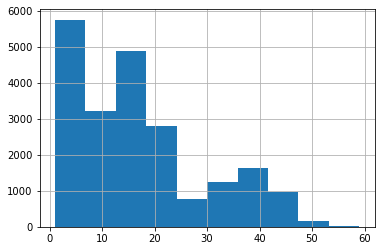

In [25]:
df_final_samsung['release_count'].hist()

In [126]:
grouped = df_final_samsung.groupby(['device'])

df_filtered = grouped.filter(lambda x: x['release_count'].mean()>38)

df_filtered['device'].unique()

array(['Galaxy S20+ 5G', 'Galaxy S20 Ultra', 'Galaxy S10e',
       'Galaxy S20 5G', 'Galaxy S10', 'Galaxy Fold 5G', 'Galaxy S10+'],
      dtype=object)

In [127]:
df_filtered['first_OS'].value_counts()

Pie(Android 9)    648
Q(Android 10)     399
Name: first_OS, dtype: int64

In [128]:
df_filtered['android_versions_count'].value_counts()

4    1023
3      15
2       5
1       4
Name: android_versions_count, dtype: int64

 ### Support Duration

In [129]:
df_final_samsung['release_date_duration'].mean()

Timedelta('757 days 10:05:25.763011976')

In [134]:
grouped = df_final_samsung.groupby(['device'])

df_filtered = grouped.filter(lambda x: x['release_date_duration'].dt.days.mean()>4*365)

df_filtered['device'].unique()

array(['Galaxy Note8', 'Galaxy S9+', 'Galaxy S9', 'Galaxy A8 Star',
       'Galaxy S8 Lite', 'Galaxy S8+', 'Galaxy On7 (2015)',
       'Galaxy Tab A Plus 9.7', 'Galaxy S8',
       'Galaxy Tab A 10.1" w/ S-Pen'], dtype=object)

In [135]:
grouped = df_final_samsung.groupby(['device'])

df_filtered = grouped.filter(lambda x: x['release_date_duration'].dt.days.mean()>5*365)

df_filtered['device'].unique()

array(['Galaxy S8+', 'Galaxy Tab A Plus 9.7', 'Galaxy S8'], dtype=object)

In [137]:
df_final_samsung[df_final_samsung['release_date_duration'].dt.days>(365*6)].reset_index()

,index,id,device,model,CSC,device_type,aer,platform,carrier_country,carrier,...,SPL_duration,release_date_duration,SPL_count,release_count,SPL_freq,avg_release_freq,first_release_date,last_release_date,avg_release_delay,url
0,12821,SM-G930F/BRI,Galaxy S7,SM-G930F,BRI,smartphone,False,Knox,Taiwan,No-carrier,...,731 days,2311 days,30,30,24.366667,77.033333,2016-04-20,2022-08-18,102.0,https://doc.samsungmobile.com/SM-G930F/BRI/doc...
1,12930,SM-G930F/TGY,Galaxy S7,SM-G930F,TGY,smartphone,False,Knox,Hong Kong,No-carrier,...,609 days,2332 days,30,30,20.300000,77.733333,2016-03-30,2022-08-18,119.0,https://doc.samsungmobile.com/SM-G930F/TGY/doc...
2,12987,SM-G930K/KTC,Galaxy S7,SM-G930K,KTC,smartphone,False,Knox,Korea (KT Corporation),KT Corporation,...,823 days,2346 days,31,31,26.548387,75.677419,2016-03-16,2022-08-18,92.0,https://doc.samsungmobile.com/SM-G930K/KTC/doc...
3,12988,SM-G930L/LUC,Galaxy S7,SM-G930L,LUC,smartphone,False,Knox,Korea (LG Uplus),LG Uplus,...,823 days,2336 days,30,30,27.433333,77.866667,2016-03-26,2022-08-18,91.0,https://doc.samsungmobile.com/SM-G930L/LUC/doc...
4,12989,SM-G930S/SKC,Galaxy S7,SM-G930S,SKC,smartphone,False,Knox,Korea (SK Telecom),SK Telecom,...,823 days,2336 days,31,31,26.548387,75.354839,2016-03-26,2022-08-18,93.0,https://doc.samsungmobile.com/SM-G930S/SKC/doc...
5,13037,SM-G935F/BRI,Galaxy S7 Edge,SM-G935F,BRI,smartphone,False,Knox,Taiwan,No-carrier,...,731 days,2310 days,32,32,22.843750,72.187500,2016-04-22,2022-08-19,102.0,https://doc.samsungmobile.com/SM-G935F/BRI/doc...
6,13213,SM-G935K/KTC,Galaxy S7 Edge,SM-G935K,KTC,smartphone,False,Knox,Korea (KT Corporation),KT Corporation,...,823 days,2348 days,32,32,25.718750,73.375000,2016-03-14,2022-08-18,92.0,https://doc.samsungmobile.com/SM-G935K/KTC/doc...
7,13214,SM-G935L/LUC,Galaxy S7 Edge,SM-G935L,LUC,smartphone,False,Knox,Korea (LG Uplus),LG Uplus,...,823 days,2336 days,30,30,27.433333,77.866667,2016-03-26,2022-08-18,91.0,https://doc.samsungmobile.com/SM-G935L/LUC/doc...
8,13215,SM-G935S/SKC,Galaxy S7 Edge,SM-G935S,SKC,smartphone,False,Knox,Korea (SK Telecom),SK Telecom,...,823 days,2336 days,30,30,27.433333,77.866667,2016-03-26,2022-08-18,93.0,https://doc.samsungmobile.com/SM-G935S/SKC/doc...
9,13760,SM-A510Y/BRI,Galaxy A5 (2016),SM-A510Y,BRI,smartphone,False,Knox,Taiwan,No-carrier,...,0 days,2343 days,25,25,0.000000,93.720000,2016-03-09,2022-08-08,1529.0,https://doc.samsungmobile.com/SM-A510Y/BRI/doc...


In [138]:
df_final_samsung[df_final_samsung['release_date_duration'].dt.days>(365*6)]['country'].value_counts()

Korea        13
Taiwan        4
Hong Kong     1
Name: country, dtype: int64

 ### Update Frequency

In [139]:
df_final_samsung['avg_release_freq'].mean()

49.88070882115078

<AxesSubplot:>

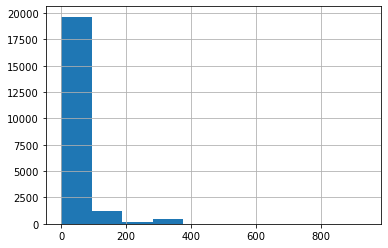

In [140]:
df_final_samsung['avg_release_freq'].hist()

In [141]:
grouped = df_final_samsung.groupby(['device'])

df_filtered = grouped.filter(lambda x: x['avg_release_freq'].mean()>200)

df_filtered['device'].unique()

array(['Galaxy On7 (2015)', 'Galaxy Tab A Plus 9.7', 'Galaxy S6',
       'Galaxy S6 edge', 'Galaxy Tab E 8.0"'], dtype=object)

 ### Release Delay

In [142]:
df_final_samsung['avg_release_delay'].mean()

140.463209664327

In [143]:
df_final_samsung['avg_release_delay'].max()

2361.0

In [145]:
len(df_final_samsung[~df_final_samsung['avg_release_delay'].isnull()])

20943

In [146]:
grouped = df_final_samsung.groupby(['device'])
  
df_filtered = grouped.filter(lambda x: (x['avg_release_delay'].mean()>70))

len(df_filtered['device'].unique())

45

In [147]:
df_filtered.groupby(['device'])['avg_release_delay'].mean().max()

2112.4615384615386

In [148]:
df_filtered.groupby(['device'])['avg_release_delay'].mean().min()

72.65243902439025

### Release delay by SPLs 

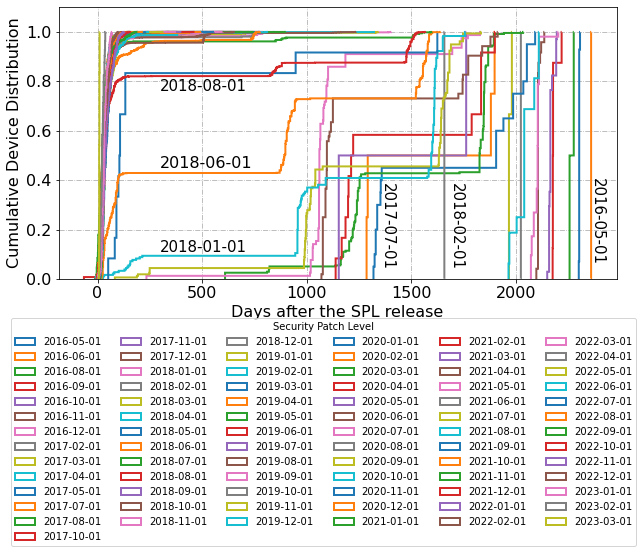

<Figure size 432x288 with 0 Axes>

In [149]:
import datetime

if pd.api.types.is_datetime64_any_dtype(df_samsung['security_patch_level']):
    df_samsung['SPL_delay'] = (df_samsung['release_date'] - df_samsung['security_patch_level']).dt.days
    df_samsung['security_patch_level'] = df_samsung['security_patch_level'].dt.date

cond1 = df_samsung['security_patch_level']>datetime.date(2016, 4, 1)
cond2 = df_samsung['security_patch_level']<datetime.date(2023, 4, 1) 

spl_list =  sorted(df_samsung[cond1&cond2]['security_patch_level'].unique())

fig, ax = plt.subplots(figsize=(10, 5))


for spl in spl_list[:]:
    column = df_samsung[df_samsung['security_patch_level']==spl]['SPL_delay']
    
    if len(column)<0:
        print('{}: '.format(spl,len(column)))
        continue
    
    n, bins, patches = ax.hist(column,bins=1000, density=True, histtype='step',cumulative=True,linewidth=2,label=spl)
    patches[0].set_xy(patches[0].get_xy()[:-1])
    
    if (0.4<n[500]<0.45) & (bins[1]<500):
        plt.text(300,n[500]+0.02,spl,fontsize=16)
        
    if (0.821<n[500]<0.822) & (bins[1]<500):
        plt.text(300,n[500]-0.06,spl,fontsize=15)
        
    if (0.14<n[500]<0.15) & (bins[1]<500):
        plt.text(300,n[500]-0.03,spl,fontsize=15)
        
    if spl==datetime.date(2018, 2, 1):
        plt.text(1680,0.05,spl,fontsize=15,rotation=270)
        
    if spl==datetime.date(2016, 5, 1):
        plt.text(2355,0.07,spl,fontsize=15,rotation=270)
        
    if spl==datetime.date(2017, 7, 1):
        plt.text(1350,0.05,spl,fontsize=15,rotation=270)
        
    #if spl==datetime.date(2017, 4, 1):
    #    plt.text(1850,0.05,spl,fontsize=15,rotation=90)


plt.ylabel('Cumulative Device Distribution',fontsize=16)
plt.xlabel('Days after the SPL release',fontsize=16)
#plt.title('Delay (days)',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.gca().yaxis.set_major_locator(plt.MultipleLocator(60))
plt.grid(linestyle='-.')
plt.legend(ncol=6,loc='lower center', bbox_to_anchor=(0.475, -1.0),title='Security Patch Level')
#plt.xlim(0, 200)
plt.ylim(0, 1.1)
plt.savefig('../Results/SPL_delays_all.pdf', bbox_inches='tight')
plt.show()
plt.tight_layout()

# 2. Xiaomi 

In [150]:
import yaml
import pandas as pd
import requests
import re

# Read the YAML file
with open('../Data/Xiaomi/latest.yml') as f:
    data = yaml.safe_load(f)

# Create a pandas dataframe from the data
df_xiaomi = pd.DataFrame(data)

# split name column by last whitespace and take first and last parts
df_xiaomi[['device', 'region']] = df_xiaomi['name'].str.rsplit(n=1, expand=True)

df_xiaomi['date']= pd.to_datetime(df_xiaomi['date'])


# Read the YAML file
with open('../Data/Xiaomi/devices.yml') as f:
    devices = yaml.safe_load(f)
    
# Create a pandas dataframe from the data
df_devices = pd.DataFrame(devices)
df_devices = df_devices.T
df_devices.reset_index(drop=False,inplace=True)
df_devices.rename(columns={'index': 'codename', 0: 'device-region', 1: 'model'},inplace=True)


# Create a new column "codename_short" by splitting the "codename" column
df_xiaomi['codename_short'] = df_xiaomi['codename'].apply(lambda x: x.split('_')[0])

def generate_url(row):
    if 'Stable' in row['branch']:
        branch_url = 'stable'
    elif 'Weekly' in row['branch']:
        branch_url = 'weekly'
    elif 'Public' in row['branch']:
        branch_url = 'public%20beta'
    else:
        branch_url = row['branch'].lower()

    return 'https://xiaomifirmwareupdater.com/miui/' + row['codename_short'] + '/' + branch_url + '/' + row['version'] + '/'

df_xiaomi['changelog_url'] = df_xiaomi.apply(generate_url, axis=1)


# Read 'changelogs.csv' and merge it with df based on 'changelog_url'
df_changelogs = pd.read_csv('../Data/Xiaomi/changelogs.csv')

df_xiaomi = pd.merge(df_xiaomi, df_changelogs, on='changelog_url', how='left')


def extract_SPL(changelog_text):
    if isinstance(changelog_text, str):   # check if changelog_text is a string
        match = re.search(r'(\bJanuary\b|\bFebruary\b|\bMarch\b|\bApril\b|\bMay\b|\bJune\b|\bJuly\b|\bAugust\b|\bSeptember\b|\bOctober\b|\bNovember\b|\bDecember\b) \d{4}', changelog_text)
        if match:
            return match.group(0)
    return None   # if changelog_text is not a string (e.g., it's a float/NaN), return None
    
df_xiaomi['SPL'] = df_xiaomi['changelog'].apply(extract_SPL)

df_xiaomi['SPL_date'] = pd.to_datetime(df_xiaomi['SPL'], format='%B %Y', errors='coerce')

df_xiaomi['delay'] = df_xiaomi['date'] - df_xiaomi['SPL_date']
# Convert timedelta values to days
df_xiaomi['delay_days'] = df_xiaomi['delay'].dt.days


# Create a new column based on the 'name' column
df_xiaomi['device_type'] = df_xiaomi['name'].apply(lambda x: 'Tablet' if 'Pad' in x else 'Smartwatch' if 'Watch' in x else 'Phone')

# Print the dataframe
df_xiaomi.head()


,android,branch,codename,date,link,md5,method,name,size,version,device,region,codename_short,changelog_url,changelog,SPL,SPL_date,delay,delay_days,device_type
0,4.2,Stable,HM2013022,2015-03-26,https://bigota.d.miui.com/JHACNBH22.0/miui_HM2...,a4bd134f029bd7d93d1cf595a4edb60a,Recovery,Redmi 1 TD China,315.9 MB,JHACNBH22.0,Redmi 1 TD,China,HM2013022,https://xiaomifirmwareupdater.com/miui/HM20130...,Bug fixes and system optimizations. Bug fixes ...,None,NaT,NaT,NaN,Phone
1,4.2,Stable,HM2013022,2015-03-26,https://bigota.d.miui.com/JHACNBH22.0/miui_HM2...,a4bd134f029bd7d93d1cf595a4edb60a,Recovery,Redmi 1 China,315.9 MB,JHACNBH22.0,Redmi 1,China,HM2013022,https://xiaomifirmwareupdater.com/miui/HM20130...,Bug fixes and system optimizations. Bug fixes ...,None,NaT,NaT,NaN,Phone
2,4.4,Weekly,HM2013022,2017-11-15,https://bigota.d.miui.com/7.11.16/miui_HMTD_7....,79d730de3e2d6c5373d12a1b23e1120a,Recovery,Redmi 1 TD China,460.1 MB,7.11.16,Redmi 1 TD,China,HM2013022,https://xiaomifirmwareupdater.com/miui/HM20130...,[Other]Fixed bugsImproved system stability [Ot...,None,NaT,NaT,NaN,Phone
3,4.4,Weekly,HM2013022,2017-11-15,https://bigota.d.miui.com/7.11.16/miui_HMTD_7....,79d730de3e2d6c5373d12a1b23e1120a,Recovery,Redmi 1 China,460.1 MB,7.11.16,Redmi 1,China,HM2013022,https://xiaomifirmwareupdater.com/miui/HM20130...,[Other]Fixed bugsImproved system stability [Ot...,None,NaT,NaT,NaN,Phone
4,4.4,Stable,HM2013023,2016-05-12,https://bigota.d.miui.com/V7.3.1.0.KHBCNDD/miu...,49c9fc7ce6be59b9a7bddd35f5a82596,Recovery,Redmi 1 W China,507.6 MB,V7.3.1.0.KHBCNDD,Redmi 1 W,China,HM2013023,https://xiaomifirmwareupdater.com/miui/HM20130...,[Other]Optimized system performanceImproved sy...,None,NaT,NaT,NaN,Phone


## 2.1 Feature extraction

In [151]:
import pandas as pd

d = []
counter = 0

for codename in df_xiaomi['codename'].unique():
    #print('codename: {}'.format(codename))
    
    df_test = df_xiaomi[df_xiaomi['codename']==codename]

    device = df_test['device'].to_list()
    region = df_test['region'].to_list()
    
    device_type = df_test['device_type'].to_list()
    
    update_count = len(df_test)
    first_update_date = df_test['date'].min()
    last_update_date = df_test['date'].max()
    support_duration = (last_update_date-first_update_date).days
    update_frequency = support_duration / update_count if update_count else None
    
    last_android_version = df_test.loc[df_test['date']==last_update_date,'android'].to_list()
    
    delay = df_test['delay_days'].median()
    
    first_SPL = df_test['SPL_date'].min()
    last_SPL = df_test['SPL_date'].max()
        
    d.append({'codename': codename,
              'name': device[0],
              'device_type': device_type[0],
              'region': region[0],
              'last_android_version': last_android_version[0],
              'update_count': update_count,
              'first_update_date': first_update_date,
              'last_update_date': last_update_date,
              'first_SPL': first_SPL,
              'last_SPL': last_SPL,
              'support_duration': support_duration,
              'update_frequency': update_frequency,
              'delay': delay})
    
    counter = counter + 1
    
    print('Completed {} / {}'.format(counter,len(df_xiaomi['codename'].unique())), end='\r')
    

df_final_xiaomi = pd.DataFrame(d)
    
df_final_xiaomi.head()

,codename,name,device_type,region,last_android_version,update_count,first_update_date,last_update_date,first_SPL,last_SPL,support_duration,update_frequency,delay
0,HM2013022,Redmi 1 TD,Phone,China,4.4,4,2015-03-26,2017-11-15,NaT,NaT,965,241.250000,NaN
1,HM2013023,Redmi 1 W,Phone,China,4.4,15,2016-05-12,2018-09-26,NaT,NaT,867,57.800000,NaN
2,HM2013023_sg_global,Redmi 1 W,Phone,Singapore,4.4,6,2015-06-26,2015-12-24,NaT,NaT,181,30.166667,NaN
3,HM2014011,Redmi 1S TD 3G,Phone,China,4.4,3,2017-11-15,2018-09-07,NaT,NaT,296,98.666667,NaN
4,HM2014501,Redmi 1S TD 4G,Phone,China,4.4,3,2017-11-15,2018-09-07,NaT,NaT,296,98.666667,NaN


- Saving for the unpatched data 

In [152]:
df_final_xiaomi[['codename','name','last_android_version','last_update_date']].to_csv('../Data/Xiaomi/Xiaomi_unpatched_devices.csv',index=False)

In [153]:
#Queried
print('===================')
print('Total Updates: {}'.format(len(df_xiaomi.index)))
print('All Devices: {}'.format(len(df_xiaomi['device'].unique())))
print('Unique Devices (combined using regional names): {}'.format(len(df_xiaomi['codename_short'].unique())))
print('Unique Pairs: {}'.format(len(df_xiaomi['codename'].unique())))
print('Unique Regions: {}'.format(len(df_xiaomi['region'].unique())))
print('Last Update Date: {}'.format(df_xiaomi['date'].max()))
print('First Update Date: {}'.format(df_xiaomi['date'].min()))
print('Unique SPLs: {}'.format(len(df_xiaomi['SPL'].unique())))
print('Last SPL: {}'.format(df_xiaomi['SPL_date'].max()))
print('First SPL: {}'.format(df_xiaomi['SPL_date'].min()))

Total Updates: 2286
All Devices: 286
Unique Devices (combined using regional names): 223
Unique Pairs: 756
Unique Regions: 10
Last Update Date: 2023-06-16 00:00:00
First Update Date: 2014-12-05 00:00:00
Unique SPLs: 46
Last SPL: 2023-06-01 00:00:00
First SPL: 2018-12-01 00:00:00


In [154]:
df_xiaomi['region'].unique()

array(['China', 'Global', 'Taiwan', 'Singapore', 'EEA', 'Indonesia',
       'Russia', 'Turkey', 'India', 'Japan'], dtype=object)

## 2.2 Initial Data Analysis

In [155]:
df_final_xiaomi[['update_count','support_duration','update_frequency','delay']].mean()

update_count          3.023810
support_duration    170.818783
update_frequency     48.225633
delay                32.776560
dtype: float64

 ### Update Count

In [156]:
df_final_xiaomi[df_final_xiaomi['update_count']>=6]['region'].value_counts()

China        35
Singapore     1
Global        1
Name: region, dtype: int64

 ### Support Duration

In [157]:
df_final_xiaomi.groupby('region').mean()

,update_count,support_duration,update_frequency,delay
region,,,,
China,4.543860,274.403509,57.731990,28.655556
EEA,2.417582,172.142857,58.410256,35.288235
Global,3.060403,210.718121,61.782942,39.070000
India,2.486111,153.458333,51.068287,30.117188
Indonesia,2.472727,83.054545,29.321212,35.028846
Japan,2.000000,8.400000,4.200000,11.800000
Russia,2.298969,75.670103,26.913230,33.221591
Singapore,6.000000,181.000000,30.166667,NaN
Taiwan,2.272727,56.181818,20.434848,29.933962


 ### Update Frequency

In [158]:
df_final_xiaomi['update_frequency'].mean()

48.22563303099016

 ### Release Delay

In [159]:
df_xiaomi.groupby('SPL_date')['delay_days'].median().sort_index()

SPL_date
2018-12-01    163.0
2019-07-01    134.0
2019-08-01     28.0
2019-09-01      3.0
2019-10-01     36.0
2019-12-01     24.0
2020-01-01    169.0
2020-03-01     20.0
2020-04-01     61.0
2020-06-01     31.5
2020-07-01     31.5
2020-08-01     45.0
2020-09-01     43.0
2020-10-01     54.5
2020-11-01     54.5
2020-12-01     55.0
2021-01-01     13.0
2021-02-01     38.0
2021-03-01     25.5
2021-05-01     35.5
2021-06-01     40.0
2021-07-01     46.0
2021-08-01     35.5
2021-09-01     55.0
2021-10-01     56.0
2021-11-01     66.5
2021-12-01     34.0
2022-01-01    402.0
2022-02-01     36.0
2022-03-01     27.0
2022-04-01     61.0
2022-05-01     59.5
2022-06-01     48.0
2022-07-01     43.0
2022-08-01     38.0
2022-09-01     26.0
2022-10-01     30.0
2022-11-01     30.0
2022-12-01     44.5
2023-01-01     44.0
2023-02-01     34.0
2023-03-01     26.0
2023-04-01     24.0
2023-05-01     19.0
2023-06-01      1.5
Name: delay_days, dtype: float64

In [160]:
df_xiaomi.groupby(df_xiaomi['SPL_date'].dt.year)['delay_days'].median().sort_index()

SPL_date
2018.0    163.0
2019.0     24.0
2020.0     46.0
2021.0     40.0
2022.0     38.0
2023.0     25.0
Name: delay_days, dtype: float64

# 3. Oppo

In [161]:
import pandas as pd
import requests
from urllib.parse import quote
import os 
import pycountry

# Read in your original DataFrame
df_oppo = pd.read_csv('../Data/Oppo/merged.csv')


df_oppo = df_oppo[~df_oppo['url'].str.endswith('%20')] 


df_oppo = df_oppo.drop_duplicates(subset=['Product Name','Version No','Size','Update Date','Download Link','url'], keep='first')

df_oppo['date']= pd.to_datetime(df_oppo['Update Date'])


df_oppo['Device Model'] = df_oppo['Version No'].str.split('_', n=1, expand=True)[0]
df_oppo['ColorOS Version'] = df_oppo['Version No'].str.split('_', n=2, expand=True)[1]
df_oppo['ColorOS Version']= df_oppo['ColorOS Version'].str.split('.', n=2, expand=True)[0]
df_oppo['region_url'] = df_oppo['url'].str.split('/').apply(lambda x: '/'.join(x[:5]))+ '/'

df_regions = pd.read_csv('../Data/Oppo/available-links-regions.csv')

#counter=0
for i in df_oppo.index:
    
    region_url = df_oppo.loc[i,'region_url']
    
    country = df_regions.loc[df_regions['Available Links'] == region_url,'Country'].tolist()
    df_oppo.at[i,'country'] = country[0]
    
    region = df_regions.loc[df_regions['Available Links'] == region_url,'Region'].tolist()
    df_oppo.at[i,'region'] = region[0]
    
    lang = df_regions.loc[df_regions['Available Links'] == region_url,'lang'].tolist()
    df_oppo.at[i,'lang'] = lang[0]
    
df_oppo['filename'] = df_oppo['Download Link'].apply(lambda x: os.path.basename(x))  
    
df_spl = pd.read_csv("../Data/Oppo/firmware_SPLs.csv")

# Rename the column
df_spl = df_spl.rename(columns={'google_patch': 'SPL'})

# Merge the dataframes
df_oppo = pd.merge(df_oppo, df_spl, on='filename', how='left')

# Replace NaN with 'NotFound'
df_oppo['SPL'] = df_oppo['SPL'].fillna('NotFound')

#Calculate delay     
df_oppo['SPL'].replace('NotFound', pd.NaT, inplace=True)
df_oppo['SPL'] = pd.to_datetime(df_oppo['SPL'], format='%Y%m%d', errors='ignore')
df_oppo['delay'] = (df_oppo['date'] - df_oppo['SPL']).dt.days

#add ISO codes
df_oppo['ISO'] = df_oppo['country'].apply(lambda x: pycountry.countries.get(name=x).alpha_3 if pycountry.countries.get(name=x) is not None else None)


df_oppo['Device Model'] = df_oppo['Device Model'].replace(dict.fromkeys(['EX','PUEX','PU','EU','TW'], ''), regex=True)

df_oppo.head()

,Product Name,Version No,Size,Update Date,Download Times,Download Link,url,date,Device Model,ColorOS Version,...,region,lang,filename,file_path,first_12_bytes,file_extension,SPL,identifier,delay,ISO
0,OPPO Reno2 F,CPH1989EX_11_C.20,2.91 GB,2021/05/10,"1,611",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/dz/software-update/so...,2021-05-10,CPH1989,11,...,Africa & Middle East,fr,CPH1989EX_11_OTA_1200_all_f5jdg3ZRx4WG.ozip,/Volumes/Expansion/Oppo/652_https___assorted.d...,OPPOENCRYPT!,ozip,2021-04-05,652.0,35.0,DZA
1,OPPO Reno2 F,CPH1989EX_11_C.19,2.87 GB,2021/03/11,"1,246",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/dz/software-update/so...,2021-03-11,CPH1989,11,...,Africa & Middle East,fr,CPH1989EX_11_OTA_1190_all_BNmwe83KIV98.ozip,/Volumes/Expansion/Oppo/651_https___assorted.d...,OPPOENCRYPT!,ozip,2021-02-05,651.0,34.0,DZA
2,OPPO Reno2 F,CPH1989EX_11_C.17,2.83 GB,2020/12/18,"7,092",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/dz/software-update/so...,2020-12-18,CPH1989,11,...,Africa & Middle East,fr,CPH1989EX_11_OTA_1170_all_UYw3OL95EtlM.ozip,/Volumes/Expansion/Oppo/650_https___assorted.d...,OPPOENCRYPT!,ozip,2020-12-05,650.0,13.0,DZA
3,OPPO Reno2 F,CPH1989EX_11_C.15,2.82 GB,2020/10/15,"5,344",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/dz/software-update/so...,2020-10-15,CPH1989,11,...,Africa & Middle East,fr,CPH1989EX_11_OTA_1150_all_HcOBVqySu4QL.ozip,/Volumes/Expansion/Oppo/649_https___assorted.d...,OPPOENCRYPT!,ozip,2020-09-05,649.0,40.0,DZA
4,OPPO Reno2 F,CPH1989_11_A.18,2.6 GB,2020/08/18,"3,986",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/dz/software-update/so...,2020-08-18,CPH1989,11,...,Africa & Middle East,fr,CPH1989EX_11_OTA_0180_all_hzB4QMDBLuVP.ozip,/Volumes/Expansion/Oppo/648_https___assorted.d...,OPPOENCRYPT!,ozip,2020-06-05,648.0,74.0,DZA


## 3.1 Feature extraction

In [162]:
import pandas as pd
from datetime import datetime
import pycountry

d = []
counter = 0

for url in df_oppo['url'].unique():
    
    df_test = df_oppo[df_oppo['url']==url]
    
    device = df_test['Product Name'].to_list()
    country = df_test['country'].to_list()
    region = df_test['region'].to_list()
    
    update_count = len(df_test)
    
    first_update_date = df_test['date'].min()
    last_update_date = df_test['date'].max()
    support_duration = (last_update_date-first_update_date).days
    update_frequency = support_duration / update_count
    
    avg_delay = df_test['delay'].median()
    
    coloros_version = df_test.loc[df_test['date']==last_update_date,'ColorOS Version'].to_list()
    
    
    d.append({'url': url,
          'device': device[0],
          'country': country[0],
          'region': region[0],
          'last_android_version': coloros_version[0],
          'update_count': update_count,
          'first_update_date': first_update_date,
          'last_update_date': last_update_date,
          'support_duration': support_duration,
          'update_frequency': update_frequency,
          'delay': avg_delay})
    
    counter = counter + 1
    
    print('Completed {} / {}'.format(counter,len(df_oppo['url'].unique())), end='\r')
    
df_final_oppo = pd.DataFrame(d)

# Assuming your DataFrame is named df_final and the column with the country names is 'country'
df_final_oppo['ISO'] = df_final_oppo['country'].apply(lambda x: pycountry.countries.get(name=x).alpha_3 if pycountry.countries.get(name=x) is not None else None)


df_final_oppo.head()
    

,url,device,country,region,last_android_version,update_count,first_update_date,last_update_date,support_duration,update_frequency,delay,ISO
0,https://support.oppo.com/dz/software-update/so...,OPPO Reno2 F,Algeria,Africa & Middle East,11,8,2019-10-14,2021-05-10,574,71.750000,37.0,DZA
1,https://support.oppo.com/dz/software-update/so...,OPPO Reno3,Algeria,Africa & Middle East,11,3,2020-09-25,2021-01-05,102,34.000000,NaN,DZA
2,https://support.oppo.com/dz/software-update/so...,OPPO A9 2020,Algeria,Africa & Middle East,11,8,2019-12-05,2021-07-26,599,74.875000,NaN,DZA
3,https://support.oppo.com/dz/software-update/so...,OPPO A11k,Algeria,Africa & Middle East,11,5,2021-04-12,2022-03-30,352,70.400000,NaN,DZA
4,https://support.oppo.com/dz/software-update/so...,OPPO A12,Algeria,Africa & Middle East,11,6,2021-01-05,2022-03-30,449,74.833333,NaN,DZA


- Saved for unpatched analysis

In [163]:
df_final_oppo[['url','device','last_android_version','last_update_date']].to_csv('../Data/Oppo/Oppo_unpatched_devices.csv',index=False)

In [164]:
#Queried
print('===================')
print('Total Updates: {}'.format(len(df_oppo.index)))
print('All Devices: {}'.format(len(df_oppo['Product Name'].unique())))
print('Unique Pairs: {}'.format(len(df_oppo['url'].unique())))
print('Unique Countries: {}'.format(len(df_oppo['country'].unique())))
print('Last Update Date: {}'.format(df_oppo['Update Date'].max()))
print('First Update Date: {}'.format(df_oppo['Update Date'].min()))
print('Unique SPLs: {}'.format(len(df_oppo['SPL'].unique())))
print('Last SPL: {}'.format(df_oppo['SPL'].max()))
print('First SPL: {}'.format(df_oppo['SPL'].min()))

Total Updates: 9373
All Devices: 72
Unique Pairs: 1124
Unique Countries: 35
Last Update Date: 2022/08/25
First Update Date: 2018/01/29
Unique SPLs: 36
Last SPL: 2021-09-05 00:00:00
First SPL: 2018-10-05 00:00:00


## 3.2 Initial Data Analysis

In [166]:
df_final_oppo[['update_count','support_duration','update_frequency','delay']].mean()

update_count          8.338968
support_duration    582.798932
update_frequency     84.369280
delay                35.367758
dtype: float64

 ### Update Count

In [168]:
df_final_oppo.groupby('device')['update_count'].mean().sort_values(ascending=False)[:10]

device
OPPO R17 Pro     23.650000
OPPO R17         21.600000
OPPO Find X      19.740741
OPPO K3          16.000000
OPPO A3          15.500000
OPPO K1          15.000000
OPPO RX17 Neo    14.111111
OPPO Reno        13.750000
OPPO F5 Youth    13.714286
OPPO F5          13.666667
Name: update_count, dtype: float64

In [169]:
df_final_oppo.groupby('device')['update_count'].mean().sort_values(ascending=True)[:10]

device
Neo 7              2.0000
OPPO Reno4 F       2.0000
OPPO Reno4 5G      2.0000
OPPO Reno4         2.0000
OPPO Reno3 A       2.0000
OPPO Reno4 Lite    2.0000
OPPO A57           2.0000
OPPO A54           2.0000
OPPO Reno4 Pro     2.0000
OPPO F1            2.0625
Name: update_count, dtype: float64

In [170]:
grouped = df_final_oppo.groupby(['device'])
  
df_filtered = grouped.filter(lambda x: (x['update_count'].mean()<2.01))

len(df_filtered['device'].unique())

9

In [171]:
df_filtered[df_filtered['device']=='OPPO Reno4']['url'].to_list()

['https://support.oppo.com/eg/software-update/software-download/?m=Reno4',
 'https://support.oppo.com/ke/software-update/software-download/?m=Reno4',
 'https://support.oppo.com/ma/software-update/software-download/?m=Reno4',
 'https://support.oppo.com/ng/software-update/software-download/?m=Reno4',
 'https://support.oppo.com/tn/software-update/software-download/?m=Reno4',
 'https://support.oppo.com/ae/software-update/software-download/?m=Reno4',
 'https://support.oppo.com/bd/software-update/software-download/?m=Reno4',
 'https://support.oppo.com/kh/software-update/software-download/?m=Reno4',
 'https://support.oppo.com/id/software-update/software-download/?m=Reno4',
 'https://support.oppo.com/my/software-update/software-download/?m=Reno4',
 'https://support.oppo.com/mm/software-update/software-download/?m=Reno4',
 'https://support.oppo.com/pk/software-update/software-download/?m=Reno4',
 'https://support.oppo.com/ph/software-update/software-download/?m=Reno4',
 'https://support.oppo.co

In [172]:
df_filtered['last_update_date'].value_counts()

2020-12-19    14
2019-05-22    10
2021-03-04     5
2019-03-21     5
2021-01-18     4
2019-05-21     3
2018-09-27     2
2020-10-09     2
2020-12-14     1
2021-05-11     1
2020-12-24     1
Name: last_update_date, dtype: int64

 ### Support Duration

In [173]:
df_final_oppo['support_duration'].mean()

582.7989323843416

In [174]:
df_final_oppo.groupby('device')['support_duration'].mean().sort_values(ascending=False)[:10]

device
OPPO F7          1113.944444
OPPO F7 128G     1082.055556
OPPO R17          964.000000
OPPO R15          964.000000
OPPO F9           925.555556
OPPO R17 Pro      894.600000
OPPO R15 Pro      888.909091
OPPO Find X       888.111111
OPPO F7 Youth     882.062500
OPPO F5           873.952381
Name: support_duration, dtype: float64

In [175]:
df_final_oppo.groupby('device')['support_duration'].mean().sort_values(ascending=True)[:10]

device
OPPO A54            21.000000
OPPO Reno4 F        38.000000
OPPO Reno4 Lite     38.000000
OPPO Reno4 5G       48.333333
OPPO F17            63.000000
OPPO A93            88.545455
OPPO F17 Pro        92.000000
OPPO A73 5G         93.000000
OPPO Reno4         104.428571
OPPO Reno3 A       116.000000
Name: support_duration, dtype: float64

 ### Update Frequency

In [176]:
df_final_oppo['update_frequency'].mean()

84.36928049643988

In [177]:
df_final_oppo.groupby('device')['update_frequency'].mean().sort_values(ascending=False)[:10]

device
OPPO F1 Plus    269.564103
OPPO F1         262.760417
OPPO A57        194.100000
OPPO A77        181.700000
Neo 7           179.000000
OPPO F3         172.995833
OPPO F3 Plus    165.641667
OPPO A37        154.750000
OPPO A15s       149.354938
OPPO F1s        145.284444
Name: update_frequency, dtype: float64

In [178]:
df_final_oppo.groupby('device')['update_frequency'].mean().sort_values(ascending=True)[:10]

device
OPPO A54           10.500000
OPPO Reno4 Lite    19.000000
OPPO Reno4 F       19.000000
OPPO Reno4 5G      24.166667
OPPO F17 Pro       28.111111
OPPO A93           30.333333
OPPO F17           30.692308
OPPO A73 5G        35.166667
OPPO Reno3         36.443543
OPPO R17 Pro       38.657629
Name: update_frequency, dtype: float64

In [179]:
grouped = df_final_oppo.groupby(['device'])
  
df_filtered = grouped.filter(lambda x: (x['update_frequency'].mean()<30))

len(df_filtered['device'].unique())

5

In [180]:
df_oppo[df_oppo['url']=='https://support.oppo.com/id/software-update/software-download/?m=A54']

,Product Name,Version No,Size,Update Date,Download Times,Download Link,url,date,Device Model,ColorOS Version,...,region,lang,filename,file_path,first_12_bytes,file_extension,SPL,identifier,delay,ISO
2405,OPPO A54,CPH2239_11_A.07,3.05 GB,2021/05/11,"10,609",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/id/software-update/so...,2021-05-11,CPH2239,11,...,Asia Pacific,id,CPH2239PU_11_OTA_0070_all_9gqfCbCilsAp.ozip,/Volumes/Expansion/Oppo/151_https___assorted.d...,PK,ozip,NaT,151.0,NaN,IDN
2406,OPPO A54,CPH2239_11_A.05,3.05 GB,2021/04/20,"3,216",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/id/software-update/so...,2021-04-20,CPH2239,11,...,Asia Pacific,id,CPH2239PU_11_OTA_0050_all_8Un6HfdeKf9P.ozip,/Volumes/Expansion/Oppo/150_https___assorted.d...,PK,ozip,NaT,150.0,NaN,IDN


 ### Release Delay

In [181]:
df_final_oppo['delay'].mean()

35.367758186397985

<AxesSubplot:>

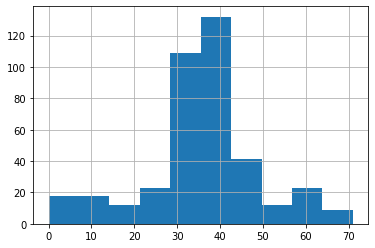

In [182]:
df_final_oppo['delay'].hist()

In [183]:
df_final_oppo.groupby('device')['delay'].mean().sort_values(ascending=False)[:10]

device
OPPO F9           54.416667
OPPO F9 Pro       52.500000
OPPO Find X2      47.272727
OPPO A91          46.675000
OPPO R15 Pro      42.318182
OPPO Reno         42.229167
OPPO Reno4 Pro    39.500000
OPPO Reno2        39.080645
OPPO F11          38.325000
OPPO F11 Pro      38.027778
Name: delay, dtype: float64

In [184]:
df_final_oppo.groupby('device')['delay'].mean().sort_values(ascending=True)[:10]

device
OPPO Reno4 F        0.000000
OPPO Reno4 Lite     0.000000
OPPO F17 Pro        4.333333
OPPO A93            5.045455
OPPO Reno4         14.000000
OPPO Reno Z        15.846154
OPPO K1            17.000000
OPPO RX17 Neo      25.285714
OPPO A9            28.500000
OPPO Find X        28.888889
Name: delay, dtype: float64

In [185]:
df_final_oppo[df_final_oppo['device']=='OPPO Reno4 F']['url'].to_list()

['https://support.oppo.com/kz/software-update/software-download/?m=Reno4%20F']

In [186]:
df_final_oppo[df_final_oppo['device']=='OPPO Reno4 Lite']['url'].to_list()

['https://support.oppo.com/id/software-update/software-download/?m=Reno4%20Lite']

# 4. Google 

In [187]:
import pandas as pd

#https://developers.google.com/android/images
df_factory  = pd.read_excel('../Data/Google/factory-images.xlsx')

#https://developers.google.com/android/ota
df_ota  = pd.read_excel('../Data/Google/ota_images.xlsx')

#https://source.android.com/docs/setup/about/build-numbers
df_tags  = pd.read_excel('../Data/Google/source_code_tags.xlsx')

#extract information from "Version" column
pattern = r'^(?P<Version2>\d+\.\d+\.\d+)\s+\((?P<Details>[^)]+)\)$'

#separate inside and outside of paranthesis (inside=details,outside=version2)
df_ota[['Version2','Details']] = df_ota['Version'].str.extract(pattern)

#separate inside of paranthesis into further parts (build, date, carriers)
df_ota[['Build', 'Date', 'Carriers']] = df_ota['Details'].str.split(',', n=2, expand=True)

#repeat for factory images
df_factory[['Version2','Details']] = df_factory['Version'].str.extract(pattern)
df_factory[['Build', 'Date', 'Carriers']] = df_factory['Details'].str.split(',', n=2, expand=True)

df_ota.to_excel('../Data/Google/ota_images_v2.xlsx',index=False)
df_factory.to_excel('../Data/Google/factory_images_v2.xlsx',index=False)


## 4.1 (Manually fixed some build numbers before run in v3) Add the SPL and other build variables

In [188]:
import pandas as pd

df_ota  = pd.read_excel('../Data/Google/ota_images_v3.xlsx')

for i in df_ota.index:
    
    build = df_ota.loc[i,'Build']
    #print(build)
    
    tag = df_tags.loc[df_tags['Build ID'] == build,'Tag'].tolist()
    try: 
        df_ota.at[i,'build_tag'] = tag[0]
    except IndexError:
        df_ota.at[i,'build_tag'] = ''
        
    version = df_tags.loc[df_tags['Build ID'] == build,'Version'].tolist()
    try: 
        df_ota.at[i,'build_version'] = version[0]
    except IndexError:
        df_ota.at[i,'build_version'] = ''
        
    supported_devices = df_tags.loc[df_tags['Build ID'] == build,'Supported devices'].tolist()
    try: 
        df_ota.at[i,'build_supported_devices'] = supported_devices[0]
    except IndexError:
        df_ota.at[i,'build_supported_devices'] = ''
        
    build_spl = df_tags.loc[df_tags['Build ID'] == build,'Security patch level'].tolist()
    try: 
        df_ota.at[i,'build_spl'] = build_spl[0]
    except IndexError:
        df_ota.at[i,'build_spl'] = ''
            
            
df_factory  = pd.read_excel('../Data/Google/factory_images_v3.xlsx')

for i in df_factory.index:
    
    build = df_factory.loc[i,'Build']
    #print(build)
    
    tag = df_tags.loc[df_tags['Build ID'] == build,'Tag'].tolist()
    try: 
        df_factory.at[i,'build_tag'] = tag[0]
    except IndexError:
        df_factory.at[i,'build_tag'] = ''
        
    version = df_tags.loc[df_tags['Build ID'] == build,'Version'].tolist()
    try: 
        df_factory.at[i,'build_version'] = version[0]
    except IndexError:
        df_factory.at[i,'build_version'] = ''
        
    supported_devices = df_tags.loc[df_tags['Build ID'] == build,'Supported devices'].tolist()
    try: 
        df_factory.at[i,'build_supported_devices'] = supported_devices[0]
    except IndexError:
        df_factory.at[i,'build_supported_devices'] = ''
        
    build_spl = df_tags.loc[df_tags['Build ID'] == build,'Security patch level'].tolist()
    try: 
        df_factory.at[i,'build_spl'] = build_spl[0]
    except IndexError:
        df_factory.at[i,'build_spl'] = ''


df_ota['Date'] = pd.to_datetime(df_ota['Date'], errors='coerce')
df_factory['Date'] = pd.to_datetime(df_factory['Date'], errors='coerce')

df_ota[['codename', 'model']] = df_ota['Device'].str.extract(r'"(.+?)" for (.+)', expand=True)
df_factory[['codename', 'model']] = df_factory['Device'].str.extract(r'"(.+?)" for (.+)', expand=True)


df_ota['build_spl'] = pd.to_datetime(df_ota['build_spl'])
df_ota['delay'] = (df_ota['Date'] - df_ota['build_spl']).dt.days

#df_factory
df_ota.head()


,Device,Version,Date,Download_Link,Version2,Details,Build,Carriers,build_tag,build_version,build_supported_devices,build_spl,codename,model,delay
0,"""cheetah"" for Pixel 7 Pro","13.0.0 (TD1A.220804.009.A2, Oct 2022)",2022-10-01,https://dl.google.com/dl/android/aosp/cheetah-...,13.0.0,"TD1A.220804.009.A2, Oct 2022",TD1A.220804.009.A2,NaN,android-13.0.0_r9,Android13,"Pixel 7, Pixel 7 Pro",2022-09-05,cheetah,Pixel 7 Pro,26.0
1,"""cheetah"" for Pixel 7 Pro","13.0.0 (TD1A.220804.009.A5, Oct 2022, JP carri...",2022-10-01,https://dl.google.com/dl/android/aosp/cheetah-...,13.0.0,"TD1A.220804.009.A5, Oct 2022, JP carriers",TD1A.220804.009.A5,JP carriers,android-13.0.0_r10,Android13,"Pixel 7, Pixel 7 Pro",2022-09-05,cheetah,Pixel 7 Pro,26.0
2,"""cheetah"" for Pixel 7 Pro","13.0.0 (TD1A.220804.031, Oct 2022)",2022-10-01,https://dl.google.com/dl/android/aosp/cheetah-...,13.0.0,"TD1A.220804.031, Oct 2022",TD1A.220804.031,NaN,android-13.0.0_r11,Android13,"Pixel 7, Pixel 7 Pro",2022-10-05,cheetah,Pixel 7 Pro,-4.0
3,"""cheetah"" for Pixel 7 Pro","13.0.0 (TD1A.221105.001, Nov 2022)",2022-11-01,https://dl.google.com/dl/android/aosp/cheetah-...,13.0.0,"TD1A.221105.001, Nov 2022",TD1A.221105.001,NaN,android-13.0.0_r13,Android13,"Pixel 7, Pixel 7 Pro",2022-11-05,cheetah,Pixel 7 Pro,-4.0
4,"""cheetah"" for Pixel 7 Pro","13.0.0 (TD1A.221105.003, Nov 2022, Verizon, Ve...",2022-11-01,https://dl.google.com/dl/android/aosp/cheetah-...,13.0.0,"TD1A.221105.003, Nov 2022, Verizon, Verizon MVNOs",TD1A.221105.003,"Verizon, Verizon MVNOs",android-13.0.0_r14,Android13,"Pixel 7, Pixel 7 Pro",2022-11-05,cheetah,Pixel 7 Pro,-4.0


In [189]:
#Queried
print('===================')
print('Total Updates: {}'.format(len(df_ota.index)))
print('All Devices: {}'.format(len(df_ota['Device'].unique())))
print('Last Update Date: {}'.format(df_ota['Date'].max()))
print('First Update Date: {}'.format(df_ota['Date'].min()))
print('Unique SPLs: {}'.format(len(df_ota['build_spl'].unique())))
print('Last SPL: {}'.format(df_ota['build_spl'].max()))
print('First SPL: {}'.format(df_ota['build_spl'].min()))

Total Updates: 1110
All Devices: 29
Last Update Date: 2023-03-01 00:00:00
First Update Date: 2016-10-01 00:00:00
Unique SPLs: 95
Last SPL: 2023-03-05 00:00:00
First SPL: 2016-04-01 00:00:00


## 4.1 Feature extraction

In [190]:
import pandas as pd
from datetime import datetime

cond1 = ~df_ota['Device'].str.contains('Nexus')
cond2 = df_ota['Date'].notna()

d = []
counter = 0

for codename in df_ota[cond1&cond2]['codename'].unique():
    
    df_test = df_ota[df_ota['codename']==codename]
    
    device = df_test['model'].to_list()[0]
    
    update_count = len(df_test['build_spl'].unique())
    first_update_date = df_test['Date'].min()
    last_update_date = df_test['Date'].max()
    support_duration = (last_update_date-first_update_date).days
    update_frequency = support_duration/update_count
    
    avg_delay = df_test['delay'].median()
    
    android_version = df_test.loc[df_test['Date']==last_update_date,'Version2'].to_list()
    
        
    d.append({'codename': codename,
          'device': device,
          'last_android_version': android_version[0],
          'update_count': update_count,
          'first_update_date': first_update_date,
          'last_update_date': last_update_date,
          'support_duration': support_duration,
          'update_frequency': update_frequency,
          'delay': avg_delay})
    
    counter = counter + 1
    
    print('Completed {} / {}'.format(counter,len(df_ota[cond1&cond2]['codename'].unique())), end='\r')
    
df_final_google = pd.DataFrame(d)
df_final_google

,codename,device,last_android_version,update_count,first_update_date,last_update_date,support_duration,update_frequency,delay
0,cheetah,Pixel 7 Pro,13.0.0,7,2022-10-01,2023-03-01,151,21.571429,-4.0
1,panther,Pixel 7,13.0.0,7,2022-10-01,2023-03-01,151,21.571429,-4.0
2,bluejay,Pixel 6a,13.0.0,9,2022-06-01,2023-03-01,273,30.333333,-4.0
3,oriole,Pixel 6,13.0.0,17,2021-10-01,2023-03-01,516,30.352941,-4.0
4,raven,Pixel 6 Pro,13.0.0,17,2021-10-01,2023-03-01,516,30.352941,-4.0
5,barbet,Pixel 5a,13.0.0,21,2021-06-01,2023-03-01,638,30.380952,-4.0
6,redfin,Pixel 5,13.0.0,31,2020-10-01,2023-03-01,881,28.419355,-4.0
7,bramble,Pixel 4a (5G),13.0.0,31,2020-10-01,2023-03-01,881,28.419355,-4.0
8,sunfish,Pixel 4a,13.0.0,34,2020-05-01,2023-03-01,1034,30.411765,-4.0
9,coral,Pixel 4 XL,13.0.0,38,2019-10-01,2023-02-01,1219,32.078947,-4.0


In [191]:
df_final_google[['codename','device','last_android_version','last_update_date']].to_csv('../Data/Google/Google_unpatched_devices.csv',index=False)

In [192]:
#Queried
print('===================')
print('Total Updates: {}'.format(len(df_ota[cond1].index)))
print('All Devices: {}'.format(len(df_ota[cond1]['Device'].unique())))
print('Last Update Date: {}'.format(df_ota[cond1]['Date'].max()))
print('First Update Date: {}'.format(df_ota[cond1]['Date'].min()))
print('Unique SPLs: {}'.format(len(df_ota[cond1]['build_spl'].unique())))
print('Last SPL: {}'.format(df_ota[cond1]['build_spl'].max()))
print('First SPL: {}'.format(df_ota[cond1]['build_spl'].min()))

Total Updates: 900
All Devices: 20
Last Update Date: 2023-03-01 00:00:00
First Update Date: 2016-10-01 00:00:00
Unique SPLs: 90
Last SPL: 2023-03-05 00:00:00
First SPL: 2016-04-01 00:00:00


## 4.2 Initial Data Analysis

In [193]:
df_final_google.groupby('device').median().sort_index()

,update_count,support_duration,update_frequency,delay
device,,,,
Pixel,38.0,1156.0,30.421053,-4.0
Pixel 2,38.0,1187.0,31.236842,-4.0
Pixel 2 XL,38.0,1187.0,31.236842,-4.0
Pixel 3,38.0,1369.0,36.026316,-4.0
Pixel 3 XL,38.0,1369.0,36.026316,-4.0
Pixel 3a,38.0,1280.0,33.684211,-4.0
Pixel 3a XL,38.0,1280.0,33.684211,-4.0
Pixel 4,38.0,1219.0,32.078947,-4.0
Pixel 4 XL,38.0,1219.0,32.078947,-4.0


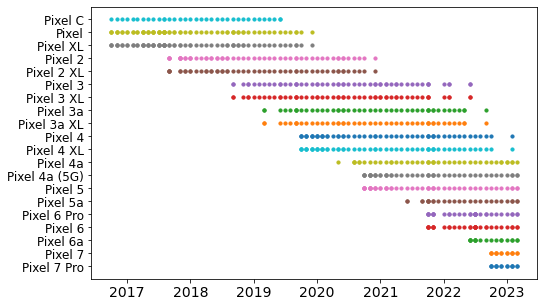

<Figure size 432x288 with 0 Axes>

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


cond1 = ~df_ota['Device'].str.contains('Nexus')
cond2 = df_ota['Date'].notna()

counter = 0
ticks = []

m = 0
k = 29

for codename in df_ota[cond1&cond2]['codename'].unique()[m:k]:
    #print('device: {}'.format(device))
    
    df_test = df_ota[df_ota['codename']==codename]
    
    dates =  df_test[df_test['Date'].notna()]['Date'].to_list()
    
    device = df_test['model'].to_list()[0]

    tick_name = device
    #tick_name = device + ' ('+codename+')'
    ticks.append(tick_name)
    
    plt.figure(1,figsize=(8, 5))
    plt.scatter(dates, [counter]*len(dates), s=10)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    #plt.gcf().autofmt_xdate()
    plt.yticks(np.arange(len(ticks)), ticks, fontsize=12)
    plt.xticks(fontsize=14,rotation=0)
    #plt.xlabel(xlabel = "Date",fontsize=16)
    counter = counter + 1

plt.savefig('../Results/Google-updates.pdf', bbox_inches='tight')
plt.show()
plt.tight_layout()

In [114]:
cond1 = ~df_ota['model'].str.contains('Nexus')
cond2 = df_ota['Date'].notna()
len(df_ota[cond1&cond2]['model'].unique())

20

In [115]:
df_ota[cond1&cond2]['model'].unique()

array(['Pixel 7 Pro', 'Pixel 7', 'Pixel 6a', 'Pixel 6', 'Pixel 6 Pro',
       'Pixel 5a', 'Pixel 5', 'Pixel 4a (5G)', 'Pixel 4a', 'Pixel 4 XL',
       'Pixel 4', 'Pixel 3a XL', 'Pixel 3a', 'Pixel 3 XL', 'Pixel 3',
       'Pixel 2 XL', 'Pixel 2', 'Pixel XL', 'Pixel', 'Pixel C'],
      dtype=object)